In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_validate

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Make the code reproducible
SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [365]:
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

# Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [366]:
df_all_declines = df_all_declines_original.copy()

# If the decline is longer than 4 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 4 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 4 * 4

# Add the decline outcome
df_all_declines['Recovered'] = df_all_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_all_declines['Category'] = df_all_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

# Add the channel's subs at the start of the decline
df_all_declines['Views_start'] = df_data_processed.loc[decline_index, 'views'].values

print(f"Overall recovery rate: {df_all_declines['Recovered'].mean():.2f}")

df_all_declines.head()

Overall recovery rate: 0.46


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start
0,UCi8IX8CVCHRKiLV_eCWEKNA,20,False,117,137,People & Blogs,32974.875000,1,1.842075e+06
1,UCi8IX8CVCHRKiLV_eCWEKNA,28,False,190,218,People & Blogs,150182.875000,3,1.236850e+07
2,UCW4jUKddkdTJwl3EFlc8ZMQ,13,True,218,231,Film and Animation,12939.125000,0,4.470020e+06
3,UC_hZX0wqyjq3CabYF25ol8Q,18,False,224,242,Gaming,16797.444444,4,5.939868e+06
4,UC-TDzpXxJndgBvyX4dZXVzA,29,False,172,201,Music,22794.200000,0,3.953500e+06


# How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we make the dataset balanced by using a matched observational study.

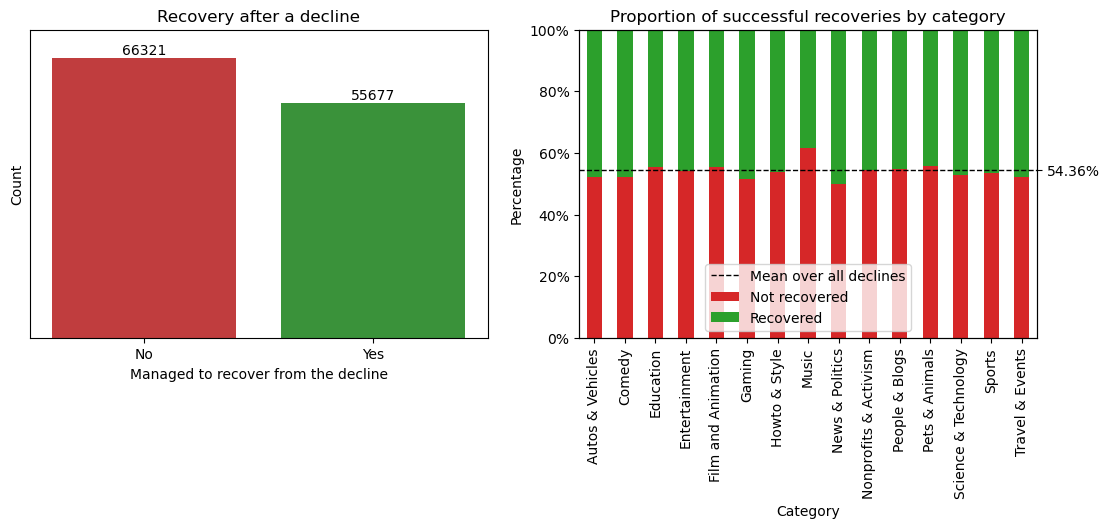

In [367]:
plot_recovered_by_categories(df_all_declines)

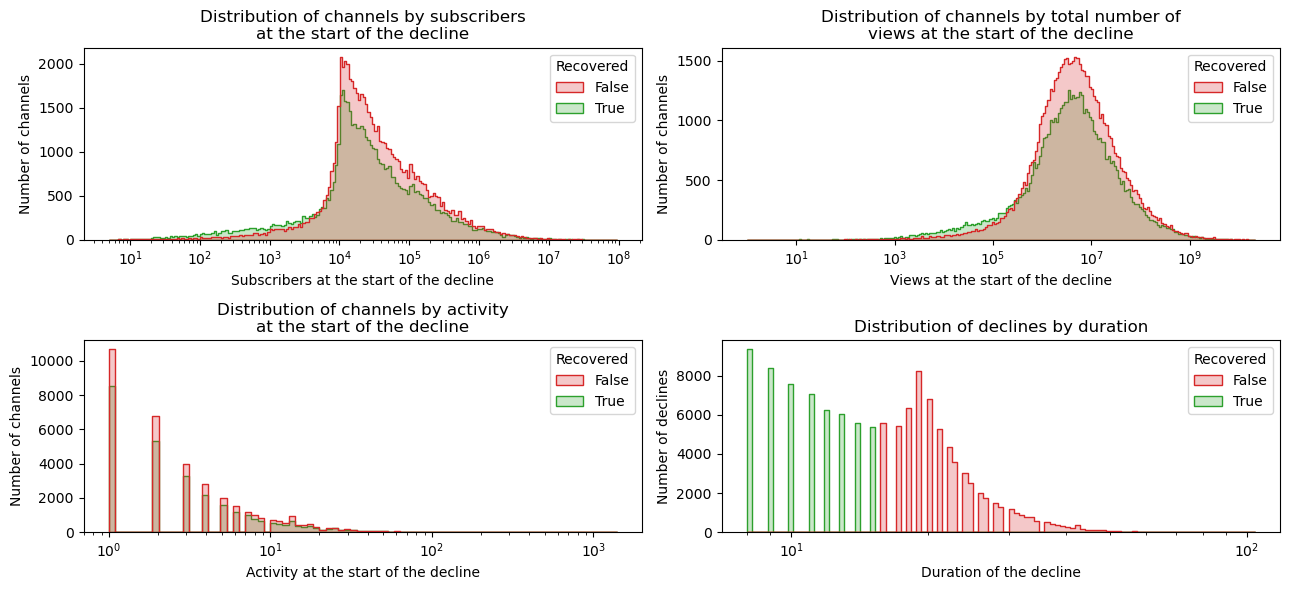

In [368]:
plot_group_distributions(df_all_declines)

Since we can observe that some features are not balanced between the treatment and control groups, especially views and subscribers at the start of the decline, we will perform matching between the two groups.

In [369]:
print(df_all_declines['Recovered'].value_counts())
print(f"\nTotal number of declines: {len(df_all_declines)}")

Recovered
False    66321
True     55677
Name: count, dtype: int64

Total number of declines: 121998


Considering the size of the dataset, we use random sampling to ease the matching's computation.

To check that sampling does not mess with the distribution of recoveries, we plot them depending on the sampling proportion.

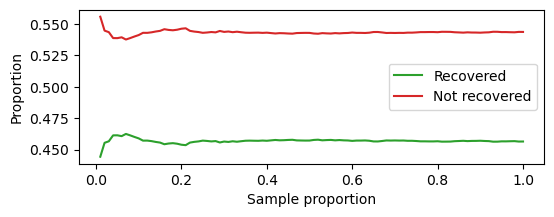

In [370]:
plot_sampling_rates(df_all_declines, SEED)

We choose to sample 30% of the data since the distribution of recoveries is left mostly unchanged, and it allows to keep a representative sample of the data.

In [371]:
df_sampled = df_all_declines.sample(frac=0.3, replace=False, random_state=SEED)

print(df_sampled['Recovered'].value_counts())
print(f"\nTotal number of declines after sampling: {len(df_sampled)}")

Recovered
False    19897
True     16702
Name: count, dtype: int64

Total number of declines after sampling: 36599


# YouTuber reactions

As we want to find the best ways to deal with a decline depending on the situation, we then take a look at how the YouTubers reacted to the decline, and what methods proved effective.

### Adding the reaction metrics whose impact we want to measure

In [372]:
# Load the videos around the declines, from week (decline start - decline duration) to week (decline end)
videos_around_declines = pd.read_csv('data/videos_around_declines.csv')

# Add the declines with the indices of the corresponding videos
df_sampled = get_sampled_declines_with_videos(df_sampled, videos_around_declines)

# Augment the data with the video stats : videos per week and mean video duration, before and during the declines
df_sampled = add_video_stats(df_sampled, videos_around_declines)

DIV_BY_ZERO_TOLERANCE = 1e-6

# Indicate whether the channel increased mean video duration after the start of the decline. We include a tolerance of 50% change.
df_sampled['Mean_duration_difference'] = df_sampled.apply(lambda row: row['Mean_duration_after'] - row['Mean_duration_before'], axis=1)
df_sampled['Posted_longer_videos'] = df_sampled.apply(lambda row: (row['Mean_duration_difference']) / np.max([row['Mean_duration_before'], DIV_BY_ZERO_TOLERANCE]) > 0.5, axis=1)
df_sampled['Posted_shorter_videos'] = df_sampled.apply(lambda row: (row['Mean_duration_difference']) / np.max([row['Mean_duration_before'], DIV_BY_ZERO_TOLERANCE]) < -0.5, axis=1)
df_sampled = df_sampled.drop(['Mean_duration_before', 'Mean_duration_after'], axis=1) # The actual mean durations are not needed anymore
print(f"\n{df_sampled['Posted_longer_videos'].mean() * 100:.2f}% of the channels posted longer videos after the start of the decline.")
print(f"{df_sampled['Posted_shorter_videos'].mean() * 100:.2f}% of the channels posted shorter videos after the start of the decline.\n")

# Indicate whether the channel changed publishing frequency after the start of the decline. We include a tolerance of 100% change (doubling the frequency).
df_sampled['Mean_frequency_difference'] = df_sampled.apply(lambda row: row['Videos_per_week_after'] - row['Videos_per_week_before'], axis=1)
df_sampled['Posted_more'] = df_sampled.apply(lambda row: (row['Mean_frequency_difference']) / np.max([row['Videos_per_week_before'], DIV_BY_ZERO_TOLERANCE]) > 0.5, axis=1)
df_sampled['Posted_less'] = df_sampled.apply(lambda row: (row['Mean_frequency_difference']) / np.max([row['Videos_per_week_before'], DIV_BY_ZERO_TOLERANCE]) < -0.5, axis=1)
df_sampled = df_sampled.drop(['Videos_per_week_before', 'Videos_per_week_after'], axis=1) # The actual frequencies are not needed anymore
print(f"{df_sampled['Posted_more'].mean() * 100:.2f}% of the channels posted more videos after the start of the decline.")
print(f"{df_sampled['Posted_less'].mean() * 100:.2f}% of the channels posted less videos after the start of the decline.")

# Drop the declines with missing data (usually due to having no video before or after the decline, or no category)
df_sampled = df_sampled.dropna()

# Keep a copy of the declines that have videos before and after the decline
df_sampled_without_zero_videos = df_sampled[(df_sampled['Videos_before'].apply(len) > 0) & (df_sampled['Videos_after'].apply(len) > 0)]

# Drop the indices of the videos, they are not needed anymore
df_sampled = df_sampled.drop(['Videos_before', 'Videos_after'], axis=1)
df_sampled_without_zero_videos = df_sampled_without_zero_videos.drop(['Videos_before', 'Videos_after'], axis=1)

df_sampled.head()

Sampled declines with videos loaded from file.

12.08% of the channels posted longer videos after the start of the decline.
6.52% of the channels posted shorter videos after the start of the decline.

22.65% of the channels posted more videos after the start of the decline.
24.69% of the channels posted less videos after the start of the decline.


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Mean_duration_difference,Posted_longer_videos,Posted_shorter_videos,Mean_frequency_difference,Posted_more,Posted_less
0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.753062e+07,419.748120,True,False,-0.250000,False,False
1,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,2.758465e+07,1432.453191,True,False,-1.214286,False,False
2,UCWmJyyUVP6AoR79IA9MTNpQ,30,False,192,222,People & Blogs,14676.662037,0,5.199927e+06,-7.000000,False,False,0.000000,False,False
3,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,3.935174e+06,-177.302463,False,False,0.428571,False,False
4,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,2.818956e+06,-249.533333,False,False,-0.600000,False,False


### Propensity score matching

Seeing that the declines do not have the same distribution on their features, we perform propensity score matchings to balance the treatment and control groups looking at the effect that changing publication frequency,video duration and video category after the start of the decline have on the recovery.

After the propensity score matching, we can observe the effect of the different treatments on the recovery :

Matches loaded from file for treatment Posted_more.
Posted_more matches : [(33079, 5), (20338, 9), (11536, 12), (26427, 14), (22389, 18), (14948, 25), (10577, 37), (27983, 42), (12882, 43), (16322, 47), (21514, 52), (34946, 59), (24847, 63), (30956, 65), (34247, 68), (3887, 78), (4098, 92), (12101, 96), (8780, 98), (21336, 107), (28343, 109), (34293, 110), (1200, 111), (8579, 121), (28626, 125), (9718, 136), (27279, 140), (24835, 141), (34262, 143), (5003, 160), (33519, 165), (20930, 179), (22329, 180), (28188, 195), (19485, 206), (36556, 210), (10019, 215), (2, 218), (12541, 225), (30456, 229), (465, 236), (1612, 237), (32103, 245), (12363, 248), (13354, 251), (35462, 268), (33753, 272), (19558, 276), (20484, 279), (30269, 283), (10131, 286), (19680, 287), (19159, 308), (24027, 311), (6975, 314), (19951, 316), (6822, 323), (2890, 328), (19042, 329), (5234, 330), (9764, 334), (21824, 338), (35192, 341), (486, 349), (14308, 356), (14926, 361), (14764, 363), (31877, 371), (28466, 376), (

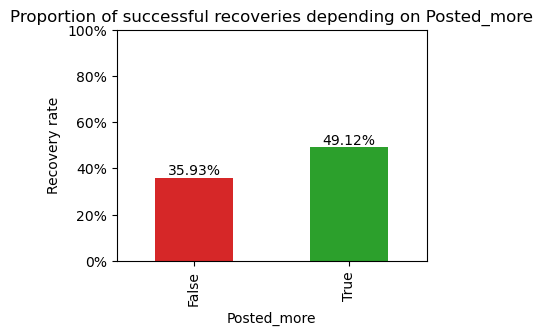

Matches loaded from file for treatment Posted_less.
Posted_less matches : [(26773, 8), (18923, 20), (20147, 27), (1382, 31), (30398, 33), (27851, 39), (29572, 40), (21096, 49), (5963, 61), (17946, 69), (2025, 71), (10080, 72), (21979, 79), (9018, 85), (2400, 91), (3232, 100), (20766, 113), (34597, 116), (33582, 117), (36404, 118), (13572, 142), (13465, 146), (33222, 149), (6721, 152), (6265, 154), (21849, 155), (7487, 156), (11108, 159), (18426, 164), (15526, 173), (17831, 177), (31141, 184), (15775, 187), (1198, 204), (32946, 220), (6314, 233), (29204, 238), (4404, 252), (30597, 261), (17104, 265), (25093, 274), (15136, 284), (15850, 290), (32780, 291), (17581, 295), (3880, 306), (18219, 309), (13979, 315), (36512, 339), (20808, 340), (5598, 346), (18843, 351), (18317, 352), (13233, 353), (35877, 354), (36146, 360), (14342, 368), (19682, 369), (17560, 373), (21484, 374), (27278, 378), (3414, 385), (384, 387), (23669, 394), (35700, 400), (1129, 402), (931, 403), (8153, 410), (34513, 41

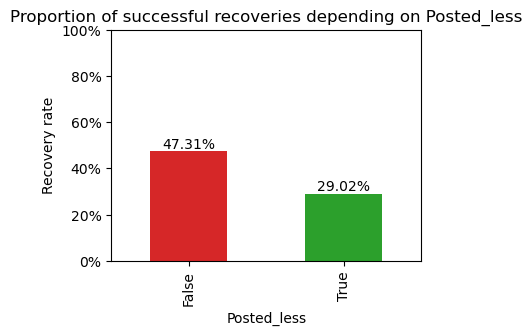

Matches loaded from file for treatment Posted_longer_videos.
Posted_longer_videos matches : [(1632, 0), (25621, 1), (33567, 15), (20935, 21), (543, 34), (32549, 39), (26502, 74), (5916, 75), (22737, 90), (35691, 94), (27840, 100), (32610, 117), (3035, 118), (18912, 133), (8390, 141), (15239, 150), (28737, 151), (19552, 159), (20272, 164), (11380, 165), (5483, 166), (2132, 169), (6204, 180), (14869, 184), (6289, 221), (35391, 233), (29984, 235), (3979, 240), (27389, 248), (17665, 252), (15951, 266), (12885, 274), (22826, 276), (190, 286), (1817, 288), (14432, 295), (9718, 305), (6824, 310), (30061, 313), (30273, 323), (27897, 332), (7351, 346), (12374, 348), (24057, 351), (20488, 352), (1172, 371), (546, 373), (8941, 375), (2327, 378), (27741, 384), (25193, 389), (21331, 394), (17966, 396), (5641, 400), (11466, 401), (6712, 404), (1414, 409), (16957, 430), (33519, 431), (6486, 433), (23879, 438), (11074, 439), (30968, 440), (31496, 468), (31181, 471), (8130, 476), (15761, 485), (17450, 

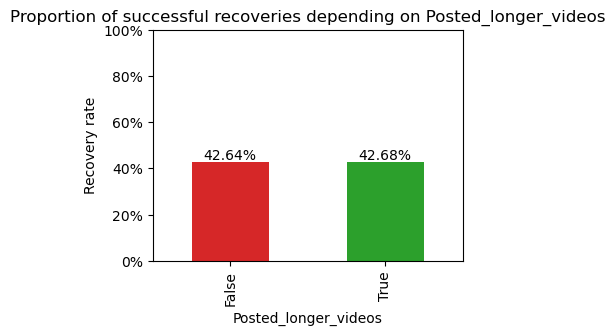

Matches loaded from file for treatment Posted_shorter_videos.
Posted_shorter_videos matches : [(9052, 9), (11563, 16), (16100, 33), (15491, 37), (23491, 47), (23904, 60), (11875, 71), (8696, 97), (20147, 140), (19409, 188), (24951, 204), (19817, 261), (4535, 283), (23469, 294), (19630, 303), (27566, 309), (35868, 354), (5356, 364), (21532, 382), (29980, 395), (8332, 410), (27058, 411), (10083, 418), (23728, 428), (13475, 429), (6976, 463), (8211, 473), (19185, 500), (33796, 515), (22808, 517), (35949, 545), (149, 571), (31350, 583), (16278, 611), (29093, 612), (4692, 635), (34953, 645), (8779, 650), (34921, 664), (23612, 692), (23838, 693), (31085, 717), (27891, 719), (25487, 720), (1732, 738), (27385, 761), (22498, 762), (1628, 763), (34142, 773), (24016, 798), (19958, 832), (27256, 857), (3380, 884), (12659, 907), (31262, 911), (28684, 936), (11304, 939), (21071, 981), (34720, 982), (17823, 985), (33913, 994), (16164, 1024), (1208, 1032), (14948, 1035), (10289, 1157), (32164, 1166), 

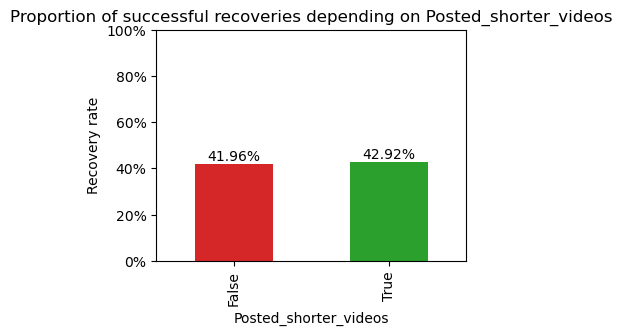

In [373]:
# The variables to be used for the matching
TREATMENTS = [
    'Posted_more',
    'Posted_less',
    'Posted_longer_videos',
    'Posted_shorter_videos',
]

# The variables to be dropped for each treatment (to avoid multicollinearity or strong correlation)
to_drop = [
    ['Mean_frequency_difference', 'Posted_less'],
    ['Mean_frequency_difference', 'Posted_more'],
    ['Mean_duration_difference', 'Posted_shorter_videos'],
    ['Mean_duration_difference', 'Posted_longer_videos'],
]

matched_dfs = {}
for treatment, dropped in zip(TREATMENTS, to_drop):
    # Try to load the matches from the file, otherwise compute them
    matches = get_matches(treatment=treatment, declines=df_sampled.drop(dropped, axis=1), verbose=False)

    print(f"{treatment} matches :", matches)

    # Flatten
    matches = [index for match in matches for index in match]

    # Get the matched declines
    matched_dfs[treatment] = df_sampled.loc[matches]

    plot_treatment_effect(matched_dfs[treatment], treatment)

## Using ML methods

### 1. Logistic regression

In [374]:
def perform_logistic_regression(X, y):
    # Make X and y numeric, and add a constant
    X = X.astype(float)
    y = y.astype(float)
    X = sm.add_constant(X)

    # Fit the logistic regression
    logit_model = sm.Logit(y, X)
    results = logit_model.fit(disp=0)

    return results

def plot_logit_coefficients(logit_result, title=None, ax=None, color_legend=True):
    # use p-values as the palette
    cmap = plt.cm.coolwarm
    reg_data = pd.DataFrame({'coeff': logit_result.params, 'p-value': logit_result.pvalues, 'se': logit_result.bse.values}).sort_values('coeff', ascending=True)
    norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.05, vmax=1)
    colors = cmap(norm(reg_data['p-value']))

    ax.vlines(0, 0, len(reg_data), color='grey', alpha=0.75, linestyle='--', linewidth=0.5)


    ax.barh(reg_data.index, reg_data['coeff'], color=colors, height=0.6)
    ax.set_title(title if title else 'Logistic regression coefficients for recovery')
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Feature')
    
    # add the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('p-value')

    if not color_legend:
        cbar.remove()

def plot_coeffs_comparison_by_removing_no_videos_declines(results_all_declines, results_without_no_videos_declines):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)
    fig.suptitle('Logistic regression coefficients for recovery')
    [ax.grid(axis='y', linestyle='--', alpha=0.2) for ax in axes]
    # put the grid  behind
    [ax.set_axisbelow(True) for ax in axes]

    plot_logit_coefficients(results_all_declines, title='All declines', ax=axes[0], color_legend=False)
    plot_logit_coefficients(results_without_no_videos_declines, title='Without declines with no videos', ax=axes[1])

    plt.tight_layout()
    plt.show()

First, do the regression on all the declines that we kept until now.

As a sanity check, we run the same regression, removing the declines that have no videos either before, during or both to check that the presence of zeros does not have a significant impact on the results.

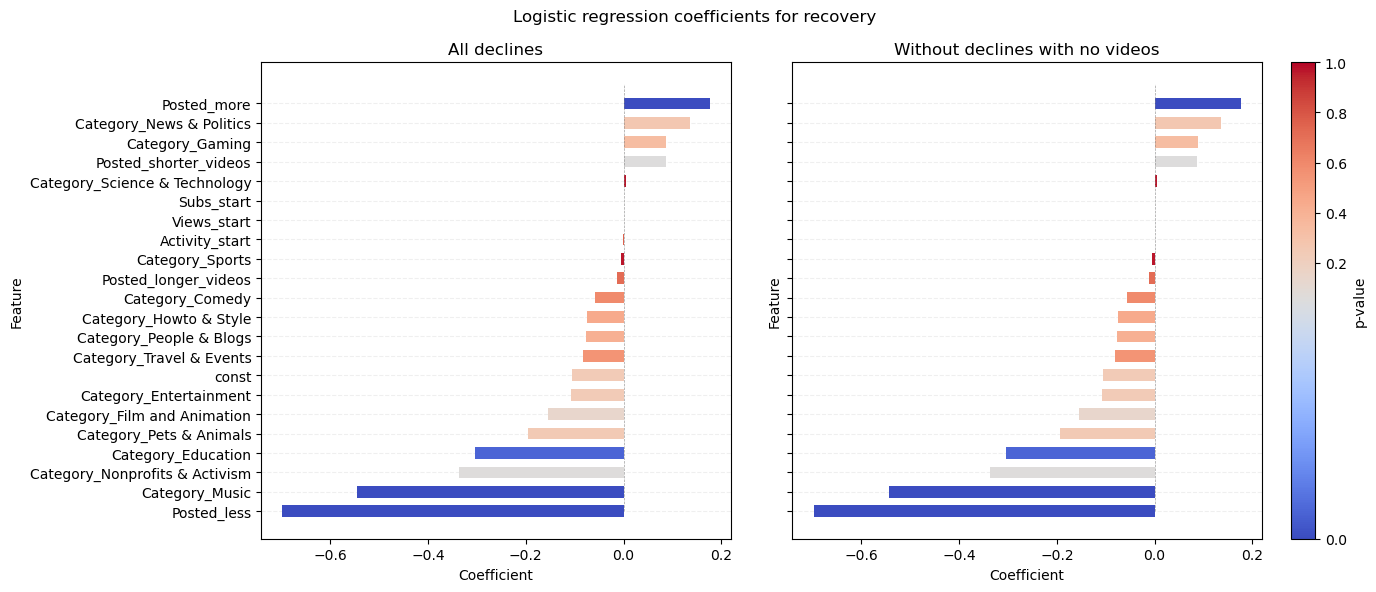

In [375]:
drop_cols = ['Channel', 'Start', 'End', 'Duration', 'Recovered', 'Mean_duration_difference', 'Mean_frequency_difference']

logit_X = df_sampled.drop(drop_cols, axis=1)
logit_X = pd.get_dummies(logit_X, columns=['Category'], drop_first=True)
logit_y = df_sampled['Recovered']

logit_result = perform_logistic_regression(logit_X, logit_y)

logit_X = df_sampled_without_zero_videos.drop(drop_cols, axis=1)
logit_X = pd.get_dummies(logit_X, columns=['Category'], drop_first=True)
logit_y = df_sampled_without_zero_videos['Recovered']

logit_without_no_videos_result = perform_logistic_regression(logit_X, logit_y)

plot_coeffs_comparison_by_removing_no_videos_declines(logit_result, logit_without_no_videos_result)

### 2. Decision tree

Decision tree accuracy: 0.59


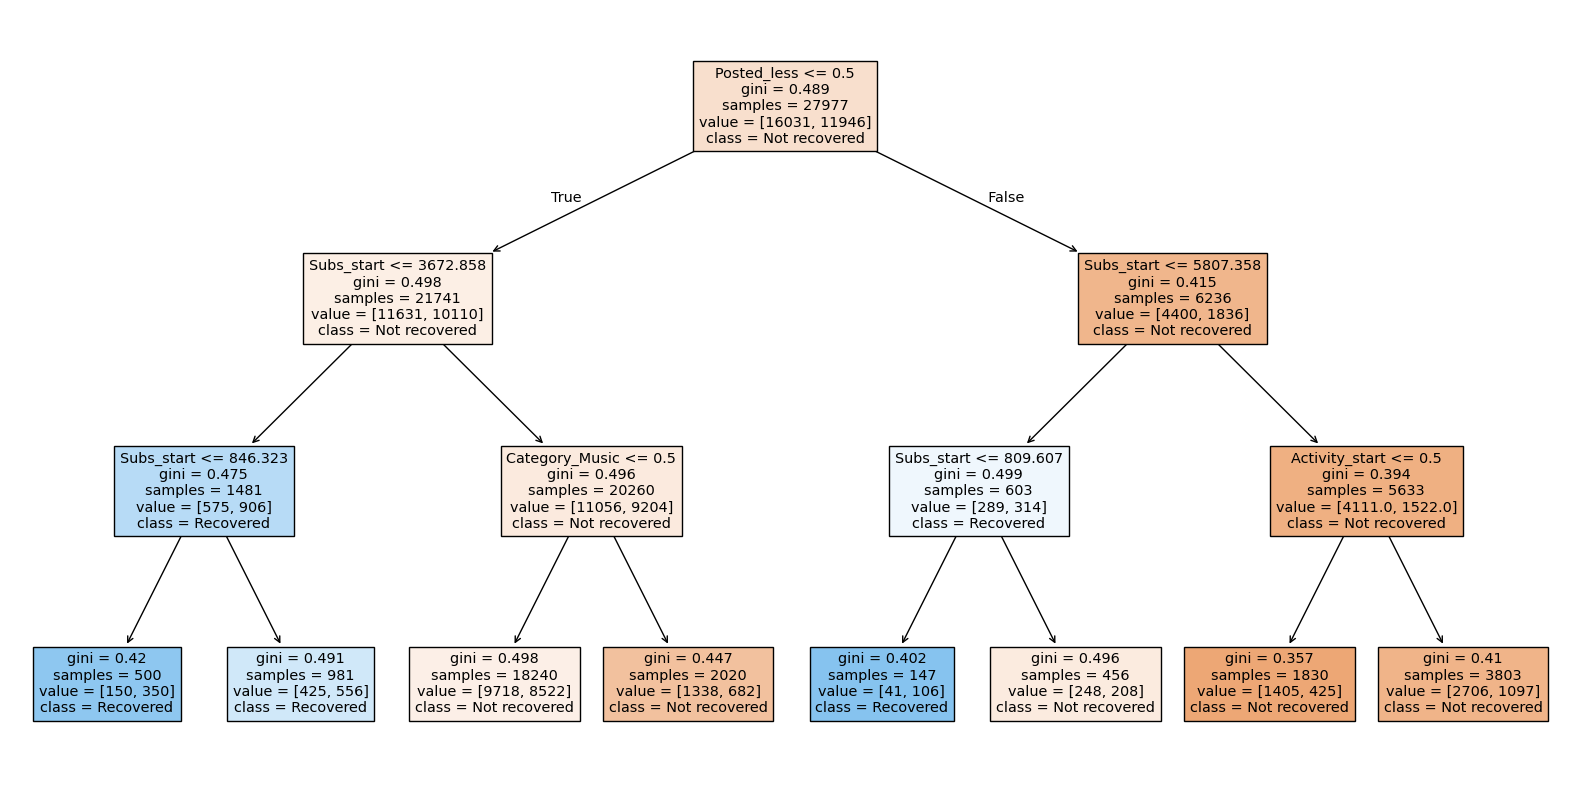

In [376]:
def perform_decision_tree(X, y):
    # Create the decision tree model
    tree = DecisionTreeClassifier(max_depth=3, random_state=SEED)

    # Evaluate the model using cross-validation
    cv_results = cross_validate(tree, X, y, cv=5, scoring='accuracy')

    # Fit the model on the whole dataset
    tree.fit(X, y)

    return tree, cv_results

tree_X = df_sampled.drop(drop_cols, axis=1)
tree_X = pd.get_dummies(tree_X, columns=['Category'], drop_first=True)

tree_y = df_sampled['Recovered']

tree, cv_results = perform_decision_tree(tree_X, tree_y)

print(f"Decision tree accuracy: {cv_results['test_score'].mean():.2f}")

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=tree_X.columns, class_names=['Not recovered', 'Recovered'])
plt.show()